# GLAM: GAM-LSTM Additive Model for District Heating Forecasting

논문 구조 그대로 구현:
- **Stage I**: GAM (Generalized Additive Model) - 구조적 baseline
- **Stage II**: Seq2Seq LSTM - 잔차 동역학 모델링

## 핵심 컴포넌트
1. HDH (Heating Degree Hours)
2. Piecewise linear trend with changepoints
3. Nonlinear weather response (B-splines)
4. Decomposed multi-seasonality (Fourier + categorical)
5. Residual dynamics (LSTM)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import Lasso

# GAM library
from pygam import LinearGAM, s, f, l
from pygam.terms import TermList

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['figure.figsize'] = (14, 6)

print("Libraries loaded successfully")


Libraries loaded successfully


## 1. Data Loading & Preprocessing

In [2]:
# 강남만 일단 배치해서 확인한다.
df = pd.read_csv('/Users/zongseung/Heat-Demand/CHP-project/gangnam_CHP.csv')

In [3]:
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)

print(f"Data shape: {df.shape}")
print(df.head())

Data shape: (26279, 11)
   Unnamed: 0 branch  heat_demand  year  month  day  hour                date  \
0         224     강남          663  2021      1    1     1 2021-01-01 01:00:00   
1         243     강남          656  2021      1    1     2 2021-01-01 02:00:00   
2         267     강남          635  2021      1    1     3 2021-01-01 03:00:00   
3         656     강남          622  2021      1    1     4 2021-01-01 04:00:00   
4         717     강남          603  2021      1    1     5 2021-01-01 05:00:00   

          ymd  imputated_temperature season  
0  2021-01-01                   -7.2     겨울  
1  2021-01-01                   -7.6     겨울  
2  2021-01-01                   -8.2     겨울  
3  2021-01-01                   -8.1     겨울  
4  2021-01-01                   -8.7     겨울  


## 2. Feature Engineering - GLAM 논문 구조

### 2.1 HDH (Heating Degree Hours) - 논문 식 (3)

In [4]:
def compute_hdh(temp, T_base=15.0):
    """
    Heating Degree Hours (HDH)
    논문 식 (3): H_t = max(0, T_base - T_t)
    
    Args:
        temp: outdoor temperature
        T_base: heating balance temperature (default 15°C)
    """
    return np.maximum(0, T_base - temp)

# HDH 계산
T_base = 15.0
df['HDH'] = compute_hdh(df['imputated_temperature'], T_base=T_base)

print(f"HDH statistics:")
print(df['HDH'].describe())

HDH statistics:
count    26279.000000
mean         5.083622
std          6.983055
min          0.000000
25%          0.000000
50%          0.000000
75%          9.400000
max         31.900000
Name: HDH, dtype: float64


### 2.2 Time Index for Trend & Changepoints

In [5]:
# Changepoint와 Fourier는 train/val split 이후에 생성됨
# Section 3에서 생성 예정
print("Changepoint and time features will be created after train/val split in Section 3")

Changepoint and time features will be created after train/val split in Section 3


### 2.3 Multi-Seasonality Features

#### (A) Continuous Cycles: Fourier Terms - 논문 식 (8, 9, 10)

In [6]:
def add_fourier_features(df, datetime_col, period_hours, K, prefix):
    """
    Add Fourier terms for seasonality
    논문 식 (9, 10): S(τ) = Σ [a_k cos(2πkτ/P) + b_k sin(2πkτ/P)]

    Args:
        df: dataframe
        datetime_col: datetime column name
        period_hours: period in hours (24 for daily, 365.25*24 for yearly)
        K: number of Fourier orders
        prefix: column name prefix
    """
    # Convert to hours from start
    tau = (df[datetime_col] - df[datetime_col].iloc[0]).dt.total_seconds() / 3600

    for k in range(1, K+1):
        df[f'{prefix}_cos_{k}'] = np.cos(2 * np.pi * k * tau / period_hours)
        df[f'{prefix}_sin_{k}'] = np.sin(2 * np.pi * k * tau / period_hours)

    return df

# NOTE: K_daily/K_yearly will be selected via grid search before GAM training
K_daily_default = 3
K_yearly_default = 10


#### (B) Discrete Social Cycles: Non-working Day Indicator - 논문 식 (11)

In [7]:
from workalendar.asia import SouthKorea

def is_non_working_day(dt, cal):
    """
    Check if datetime is non-working day (weekend or holiday)
    논문 식 (11): I_off(t)
    
    Args:
        dt: datetime
        cal: workalendar calendar object
    """
    # workalendar의 is_working_day 메서드 사용 (반대 논리)
    return 0 if cal.is_working_day(dt) else 1

# 한국 달력 객체 생성
cal = SouthKorea()

# Non-working day indicator 생성
df['is_non_working'] = df['date'].apply(lambda x: is_non_working_day(x, cal))

print(f"Non-working days: {df['is_non_working'].sum()} / {len(df)} ({100*df['is_non_working'].mean():.1f}%)")
print(f"\nSample holidays in 2021-2023:")
for year in [2021, 2022, 2023]:
    holidays = cal.holidays(year)
    print(f"  {year}: {len(holidays)} holidays")
    print(f"    Examples: {[h[1] for h in holidays[:3]]}")

Non-working days: 8231 / 26279 (31.3%)

Sample holidays in 2021-2023:
  2021: 15 holidays
    Examples: ['New year', "Korean New Year's Day", "Korean New Year's Day"]
  2022: 15 holidays
    Examples: ['New year', "Korean New Year's Day", "Korean New Year's Day"]
  2023: 15 holidays
    Examples: ['New year', "Korean New Year's Day", "Korean New Year's Day"]


In [8]:
# Train/Val/Test split (BEFORE feature engineering to prevent leakage)
# Split ratio: 8:1.5:1.5
train_ratio = 8.0 / 11.0  # 8/(9+0.5+0.5) = 72.7%
val_ratio = 1.5 / 11.0    # 1.5/11 = 13.6%

n = len(df)
train_end = int(n * train_ratio)
val_end = int(n * (train_ratio + val_ratio))

print(f"Dataset Split (8:1.5:1.5):")
print(f"  Train: 0 ~ {train_end} ({train_end} samples, {100*train_ratio:.1f}%)")
print(f"  Val:   {train_end} ~ {val_end} ({val_end - train_end} samples, {100*val_ratio:.1f}%)")
print(f"  Test:  {val_end} ~ {n} ({n - val_end} samples, {100*(1-train_ratio-val_ratio):.1f}%)")
print(f"\nWARNING: All feature engineering and hyperparameter tuning")
print(f"         should be done ONLY on train+val data to prevent leakage!")

Dataset Split (8:1.5:1.5):
  Train: 0 ~ 19112 (19112 samples, 72.7%)
  Val:   19112 ~ 22695 (3583 samples, 13.6%)
  Test:  22695 ~ 26279 (3584 samples, 13.6%)

         should be done ONLY on train+val data to prevent leakage!


In [9]:
# Now create time index AFTER split is defined
# This ensures val_end is available and prevents data leakage

# Time index for trend
df['t'] = np.arange(len(df))

# Create dataframe splits for convenience
# (Changepoints and Fourier will be added after grid search)
df_train = df.iloc[:train_end].copy()
df_val = df.iloc[train_end:val_end].copy()
df_test = df.iloc[val_end:].copy()

print(f"Time index created: t ∈ [0, {len(df)-1}]")
print(f"\nDataFrame splits created:")
print(f"  df_train: {len(df_train)} samples")
print(f"  df_val:   {len(df_val)} samples")
print(f"  df_test:  {len(df_test)} samples")


Time index created: t ∈ [0, 26278]

DataFrame splits created:
  df_train: 19112 samples
  df_val:   3583 samples
  df_test:  3584 samples


In [10]:
# =========================
# GAM feature prep + grid search for structural params (FIXED)
# =========================
import numpy as np
import pandas as pd

from pygam import LinearGAM, s, l, f
from itertools import product
from sklearn.metrics import mean_squared_error


# -------------------------
# Helper: pretty-print / summarize pyGAM lambda (often list/array per term)
# -------------------------
def _lam_to_array(gam_lam):
    """
    Convert pyGAM's gam.lam (can be scalar, list, list-of-lists, np array)
    into a flat float numpy array.
    """
    try:
        arr = np.array(gam_lam, dtype=float).ravel()
    except Exception:
        # Fallback: try flattening nested lists
        flat = []
        if isinstance(gam_lam, (list, tuple, np.ndarray)):
            for x in gam_lam:
                if isinstance(x, (list, tuple, np.ndarray)):
                    flat.extend(list(np.array(x, dtype=float).ravel()))
                else:
                    flat.append(float(x))
        else:
            flat = [float(gam_lam)]
        arr = np.array(flat, dtype=float).ravel()
    return arr


def _lam_to_str(gam_lam, max_items=10):
    arr = _lam_to_array(gam_lam)
    if arr.size == 0:
        return "[]"
    if arr.size <= max_items:
        return "[" + ", ".join(f"{x:.4f}" for x in arr) + "]"
    head = ", ".join(f"{x:.4f}" for x in arr[:max_items])
    return "[" + head + ", ...]"


# =========================
# Control flags / defaults
# =========================
RUN_GAM_GRID_SEARCH = True

K_daily_default = 3
K_yearly_default = 10
K_changepoints_default = 10


# =========================
# Grid Search (TRAIN + VAL ONLY)
# =========================
if RUN_GAM_GRID_SEARCH:
    K_daily_candidates = [2, 3, 4, 5]
    K_yearly_candidates = [5, 10, 15]
    K_changepoints_candidates = [5, 10, 15, 20]

    gam_cv_results = []

    print("Grid Search for GAM Structural Parameters (TRAIN+VAL ONLY)")
    print("=" * 80)

    for K_d, K_y, K_cp in product(K_daily_candidates, K_yearly_candidates, K_changepoints_candidates):
        # Work with a copy of df
        df_trial = df.copy()

        # Remove old Fourier features
        df_trial = df_trial.drop(
            columns=[col for col in df_trial.columns if ("daily_" in col) or ("yearly_" in col)],
            errors="ignore"
        )

        # Add new Fourier features (deterministic time functions)
        df_trial = add_fourier_features(df_trial, "date", period_hours=24, K=K_d, prefix="daily")
        df_trial = add_fourier_features(df_trial, "date", period_hours=365.25 * 24, K=K_y, prefix="yearly")

        # Recreate changepoints
        df_trial = df_trial.drop(columns=[c for c in df_trial.columns if c.startswith("cp_")], errors="ignore")

        # Use only TRAIN+VAL length for changepoint locations (prevents leakage into TEST horizon)
        changepoint_locs_trial = np.linspace(0, val_end, K_cp + 2)[1:-1].astype(int)
        for j, c_j in enumerate(changepoint_locs_trial):
            df_trial[f"cp_{j}"] = np.maximum(0, df_trial["t"] - c_j)

        # Update feature columns
        fourier_cols_trial = [col for col in df_trial.columns if ("daily_" in col) or ("yearly_" in col)]
        feature_cols_trial = ["t", "HDH", "is_non_working"]
        feature_cols_trial += [f"cp_{j}" for j in range(K_cp)]
        feature_cols_trial += fourier_cols_trial

        # Define GAM terms
        idx_t = 0
        idx_hdh = 1
        idx_nonwork = 2

        gam_terms_trial = (
            l(idx_t) +                      # linear trend base
            s(idx_hdh, n_splines=15) +       # smooth weather response
            f(idx_nonwork)                   # factor for social/non-working indicator
        )

        # Add linear terms for changepoints and Fourier features
        for i, col in enumerate(feature_cols_trial):
            if col.startswith("cp_") or col.startswith("daily_") or col.startswith("yearly_"):
                gam_terms_trial += l(i)      # keep as linear terms

        # Train on TRAIN split only
        X_train_trial = df_trial.iloc[:train_end][feature_cols_trial].values
        y_train_trial = df_trial.iloc[:train_end]["heat_demand"].values

        gam_trial = LinearGAM(gam_terms_trial)

        # NOTE: gridsearch tunes smoothing penalties; keep as-is for your workflow
        gam_trial.gridsearch(X_train_trial, y_train_trial, lam=np.logspace(-3, 3, 7))

        # Validate on VAL split
        X_val_trial = df_trial.iloc[train_end:val_end][feature_cols_trial].values
        y_val_trial = df_trial.iloc[train_end:val_end]["heat_demand"].values
        y_val_pred = gam_trial.predict(X_val_trial)
        val_rmse = float(np.sqrt(mean_squared_error(y_val_trial, y_val_pred)))

        lam_arr = _lam_to_array(gam_trial.lam)
        lam_mean = float(lam_arr.mean()) if lam_arr.size else np.nan
        lam_max = float(lam_arr.max()) if lam_arr.size else np.nan

        gam_cv_results.append({
            "K_daily": K_d,
            "K_yearly": K_y,
            "K_changepoints": K_cp,
            "val_rmse": val_rmse,
            "n_features": len(feature_cols_trial),
            "best_lam": gam_trial.lam,          # keep original structure
            "best_lam_mean": lam_mean,
            "best_lam_max": lam_max
        })

        print(
            f"K_d={K_d}, K_y={K_y:2d}, K_cp={K_cp:2d} | Features={len(feature_cols_trial):3d} | "
            f"Val RMSE={val_rmse:8.2f} | λ_mean={lam_mean:.4f} | λ=[{_lam_to_str(gam_trial.lam)}]"
        )

    # Best GAM config
    best_gam = min(gam_cv_results, key=lambda x: x["val_rmse"])

    print(f"{'='*80}")
    print("Best GAM Configuration (from train+val):")
    print(f"  K_daily:        {best_gam['K_daily']}")
    print(f"  K_yearly:       {best_gam['K_yearly']}")
    print(f"  K_changepoints: {best_gam['K_changepoints']}")
    print(f"  Val RMSE:       {best_gam['val_rmse']:.2f}")
    print(f"  Total Features: {best_gam['n_features']}")
    print(f"  Best λ:         {_lam_to_str(best_gam['best_lam'])}")
    print(f"{'='*80}")

    K_daily_optimal = best_gam["K_daily"]
    K_yearly_optimal = best_gam["K_yearly"]
    K_changepoints_optimal = best_gam["K_changepoints"]

else:
    K_daily_optimal = K_daily_default
    K_yearly_optimal = K_yearly_default
    K_changepoints_optimal = K_changepoints_default
    gam_cv_results = []
    best_gam = {
        "K_daily": K_daily_optimal,
        "K_yearly": K_yearly_optimal,
        "K_changepoints": K_changepoints_optimal,
        "val_rmse": None,
        "n_features": None,
        "best_lam": None
    }


# =========================
# Apply optimal structural parameters to main df
# =========================

# Remove old Fourier/changepoint features if they exist
df = df.drop(columns=[c for c in df.columns if c.startswith("daily_") or c.startswith("yearly_")], errors="ignore")
df = df.drop(columns=[c for c in df.columns if c.startswith("cp_")], errors="ignore")

# Add Fourier features (deterministic time functions, typically OK to compute for entire df)
df = add_fourier_features(df, "date", period_hours=24, K=K_daily_optimal, prefix="daily")
df = add_fourier_features(df, "date", period_hours=365.25 * 24, K=K_yearly_optimal, prefix="yearly")

# Create changepoint features using TRAIN+VAL only to prevent leakage into test-derived changepoint placement
changepoint_locs = np.linspace(0, val_end, K_changepoints_optimal + 2)[1:-1].astype(int)
for j, c_j in enumerate(changepoint_locs):
    df[f"cp_{j}"] = np.maximum(0, df["t"] - c_j)

# Recreate dataframe splits to include new features
df_train = df.iloc[:train_end].copy()
df_val = df.iloc[train_end:val_end].copy()
df_test = df.iloc[val_end:].copy()

print(f"Applied GAM structural params: K_daily={K_daily_optimal}, K_yearly={K_yearly_optimal}, K_cp={K_changepoints_optimal}")
print(f"Changepoint locations (train+val): {changepoint_locs}")

# GAM feature columns
feature_cols = ["t", "HDH", "is_non_working"]
feature_cols += [f"cp_{j}" for j in range(len(changepoint_locs))]
fourier_cols = [c for c in df.columns if ("daily_" in c) or ("yearly_" in c)]
feature_cols += fourier_cols

cp_cols = [c for c in feature_cols if c.startswith("cp_")]
feature_cols_gam = [c for c in feature_cols if not c.startswith("cp_")]

print(f"Total GAM features: {len(feature_cols)}")
print("Feature categories:")
print(f"  - Trend & changepoints: 1 + {len(changepoint_locs)}")
print("  - Weather (HDH): 1")
print(f"  - Fourier (daily + yearly): {len(fourier_cols)}")
print("  - Social (non-working): 1")


  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--


 14% (1 of 7) |###                       | Elapsed Time: 0:00:00 ETA:   0:00:00
 28% (2 of 7) |#######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 42% (3 of 7) |###########               | Elapsed Time: 0:00:00 ETA:   0:00:00


Grid Search for GAM Structural Parameters (TRAIN+VAL ONLY)


 57% (4 of 7) |##############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 71% (5 of 7) |##################        | Elapsed Time: 0:00:00 ETA:   0:00:00
 85% (6 of 7) |######################    | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (7 of 7) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 14% (1 of 7) |###                       | Elapsed Time: 0:00:00 ETA:   0:00:00
 28% (2 of 7) |#######                   | Elapsed Time: 0:00:00 ETA:   0:00:00


K_d=2, K_y= 5, K_cp= 5 | Features= 22 | Val RMSE=  166.88 | λ_mean=0.1000 | λ=[[0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, ...]]


 42% (3 of 7) |###########               | Elapsed Time: 0:00:00 ETA:   0:00:00
 57% (4 of 7) |##############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 71% (5 of 7) |##################        | Elapsed Time: 0:00:00 ETA:   0:00:00
 85% (6 of 7) |######################    | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (7 of 7) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 14% (1 of 7) |###                       | Elapsed Time: 0:00:00 ETA:   0:00:00
 28% (2 of 7) |#######                   | Elapsed Time: 0:00:00 ETA:   0:00:00


K_d=2, K_y= 5, K_cp=10 | Features= 27 | Val RMSE=   55.48 | λ_mean=0.0100 | λ=[[0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, ...]]


 42% (3 of 7) |###########               | Elapsed Time: 0:00:00 ETA:   0:00:00
 57% (4 of 7) |##############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 71% (5 of 7) |##################        | Elapsed Time: 0:00:00 ETA:   0:00:00
 85% (6 of 7) |######################    | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (7 of 7) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 14% (1 of 7) |###                       | Elapsed Time: 0:00:00 ETA:   0:00:00
 28% (2 of 7) |#######                   | Elapsed Time: 0:00:00 ETA:   0:00:00


K_d=2, K_y= 5, K_cp=15 | Features= 32 | Val RMSE=   57.27 | λ_mean=1.0000 | λ=[[1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, ...]]


 42% (3 of 7) |###########               | Elapsed Time: 0:00:00 ETA:   0:00:00
 57% (4 of 7) |##############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 71% (5 of 7) |##################        | Elapsed Time: 0:00:00 ETA:   0:00:00
 85% (6 of 7) |######################    | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (7 of 7) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 14% (1 of 7) |###                       | Elapsed Time: 0:00:00 ETA:   0:00:00
 28% (2 of 7) |#######                   | Elapsed Time: 0:00:00 ETA:   0:00:00


K_d=2, K_y= 5, K_cp=20 | Features= 37 | Val RMSE=   40.76 | λ_mean=10.0000 | λ=[[10.0000, 10.0000, 10.0000, 10.0000, 10.0000, 10.0000, 10.0000, 10.0000, 10.0000, 10.0000, ...]]


 42% (3 of 7) |###########               | Elapsed Time: 0:00:00 ETA:   0:00:00
 57% (4 of 7) |##############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 71% (5 of 7) |##################        | Elapsed Time: 0:00:00 ETA:   0:00:00
 85% (6 of 7) |######################    | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (7 of 7) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 14% (1 of 7) |###                       | Elapsed Time: 0:00:00 ETA:   0:00:00
 28% (2 of 7) |#######                   | Elapsed Time: 0:00:00 ETA:   0:00:00


K_d=2, K_y=10, K_cp= 5 | Features= 32 | Val RMSE=  178.66 | λ_mean=0.0100 | λ=[[0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, ...]]


 42% (3 of 7) |###########               | Elapsed Time: 0:00:00 ETA:   0:00:00
 57% (4 of 7) |##############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 71% (5 of 7) |##################        | Elapsed Time: 0:00:00 ETA:   0:00:00
 85% (6 of 7) |######################    | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (7 of 7) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 14% (1 of 7) |###                       | Elapsed Time: 0:00:00 ETA:   0:00:00
 28% (2 of 7) |#######                   | Elapsed Time: 0:00:00 ETA:   0:00:00


K_d=2, K_y=10, K_cp=10 | Features= 37 | Val RMSE=   53.01 | λ_mean=0.0100 | λ=[[0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, ...]]


 42% (3 of 7) |###########               | Elapsed Time: 0:00:00 ETA:   0:00:00
 57% (4 of 7) |##############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 71% (5 of 7) |##################        | Elapsed Time: 0:00:00 ETA:   0:00:00
 85% (6 of 7) |######################    | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (7 of 7) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 14% (1 of 7) |###                       | Elapsed Time: 0:00:00 ETA:   0:00:00


K_d=2, K_y=10, K_cp=15 | Features= 42 | Val RMSE=   42.00 | λ_mean=0.0100 | λ=[[0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, ...]]


 28% (2 of 7) |#######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 42% (3 of 7) |###########               | Elapsed Time: 0:00:00 ETA:   0:00:00
 57% (4 of 7) |##############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 71% (5 of 7) |##################        | Elapsed Time: 0:00:00 ETA:   0:00:00
 85% (6 of 7) |######################    | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (7 of 7) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 14% (1 of 7) |###                       | Elapsed Time: 0:00:00 ETA:   0:00:00


K_d=2, K_y=10, K_cp=20 | Features= 47 | Val RMSE=  267.35 | λ_mean=0.0100 | λ=[[0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, ...]]


 28% (2 of 7) |#######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 42% (3 of 7) |###########               | Elapsed Time: 0:00:00 ETA:   0:00:00
 57% (4 of 7) |##############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 71% (5 of 7) |##################        | Elapsed Time: 0:00:00 ETA:   0:00:00
 85% (6 of 7) |######################    | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (7 of 7) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 14% (1 of 7) |###                       | Elapsed Time: 0:00:00 ETA:   0:00:00


K_d=2, K_y=15, K_cp= 5 | Features= 42 | Val RMSE=  230.01 | λ_mean=1.0000 | λ=[[1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, ...]]


 28% (2 of 7) |#######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 42% (3 of 7) |###########               | Elapsed Time: 0:00:00 ETA:   0:00:00
 57% (4 of 7) |##############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 71% (5 of 7) |##################        | Elapsed Time: 0:00:00 ETA:   0:00:00
 85% (6 of 7) |######################    | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (7 of 7) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 14% (1 of 7) |###                       | Elapsed Time: 0:00:00 ETA:   0:00:00


K_d=2, K_y=15, K_cp=10 | Features= 47 | Val RMSE=   38.96 | λ_mean=1.0000 | λ=[[1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, ...]]


 28% (2 of 7) |#######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 42% (3 of 7) |###########               | Elapsed Time: 0:00:00 ETA:   0:00:00
 57% (4 of 7) |##############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 71% (5 of 7) |##################        | Elapsed Time: 0:00:00 ETA:   0:00:00
 85% (6 of 7) |######################    | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (7 of 7) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 14% (1 of 7) |###                       | Elapsed Time: 0:00:00 ETA:   0:00:00


K_d=2, K_y=15, K_cp=15 | Features= 52 | Val RMSE=   41.42 | λ_mean=1.0000 | λ=[[1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, ...]]


 28% (2 of 7) |#######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 42% (3 of 7) |###########               | Elapsed Time: 0:00:00 ETA:   0:00:00
 57% (4 of 7) |##############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 71% (5 of 7) |##################        | Elapsed Time: 0:00:00 ETA:   0:00:00
 85% (6 of 7) |######################    | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (7 of 7) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 14% (1 of 7) |###                       | Elapsed Time: 0:00:00 ETA:   0:00:00
 28% (2 of 7) |#######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 42% (3 of 7) |###########               | Elapsed Time: 0:00:00 ETA:   0:00:00


K_d=2, K_y=15, K_cp=20 | Features= 57 | Val RMSE=  366.46 | λ_mean=0.0100 | λ=[[0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, ...]]


 57% (4 of 7) |##############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 71% (5 of 7) |##################        | Elapsed Time: 0:00:00 ETA:   0:00:00
 85% (6 of 7) |######################    | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (7 of 7) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 14% (1 of 7) |###                       | Elapsed Time: 0:00:00 ETA:   0:00:00
 28% (2 of 7) |#######                   | Elapsed Time: 0:00:00 ETA:   0:00:00


K_d=3, K_y= 5, K_cp= 5 | Features= 24 | Val RMSE=  166.08 | λ_mean=0.1000 | λ=[[0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, ...]]


 42% (3 of 7) |###########               | Elapsed Time: 0:00:00 ETA:   0:00:00
 57% (4 of 7) |##############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 71% (5 of 7) |##################        | Elapsed Time: 0:00:00 ETA:   0:00:00
 85% (6 of 7) |######################    | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (7 of 7) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 14% (1 of 7) |###                       | Elapsed Time: 0:00:00 ETA:   0:00:00
 28% (2 of 7) |#######                   | Elapsed Time: 0:00:00 ETA:   0:00:00


K_d=3, K_y= 5, K_cp=10 | Features= 29 | Val RMSE=   55.48 | λ_mean=0.0100 | λ=[[0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, ...]]


 42% (3 of 7) |###########               | Elapsed Time: 0:00:00 ETA:   0:00:00
 57% (4 of 7) |##############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 71% (5 of 7) |##################        | Elapsed Time: 0:00:00 ETA:   0:00:00
 85% (6 of 7) |######################    | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (7 of 7) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 14% (1 of 7) |###                       | Elapsed Time: 0:00:00 ETA:   0:00:00
 28% (2 of 7) |#######                   | Elapsed Time: 0:00:00 ETA:   0:00:00


K_d=3, K_y= 5, K_cp=15 | Features= 34 | Val RMSE=   52.88 | λ_mean=0.0100 | λ=[[0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, ...]]


 42% (3 of 7) |###########               | Elapsed Time: 0:00:00 ETA:   0:00:00
 57% (4 of 7) |##############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 71% (5 of 7) |##################        | Elapsed Time: 0:00:00 ETA:   0:00:00
 85% (6 of 7) |######################    | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (7 of 7) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 14% (1 of 7) |###                       | Elapsed Time: 0:00:00 ETA:   0:00:00
 28% (2 of 7) |#######                   | Elapsed Time: 0:00:00 ETA:   0:00:00


K_d=3, K_y= 5, K_cp=20 | Features= 39 | Val RMSE=   40.89 | λ_mean=10.0000 | λ=[[10.0000, 10.0000, 10.0000, 10.0000, 10.0000, 10.0000, 10.0000, 10.0000, 10.0000, 10.0000, ...]]


 42% (3 of 7) |###########               | Elapsed Time: 0:00:00 ETA:   0:00:00
 57% (4 of 7) |##############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 71% (5 of 7) |##################        | Elapsed Time: 0:00:00 ETA:   0:00:00
 85% (6 of 7) |######################    | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (7 of 7) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 14% (1 of 7) |###                       | Elapsed Time: 0:00:00 ETA:   0:00:00
 28% (2 of 7) |#######                   | Elapsed Time: 0:00:00 ETA:   0:00:00


K_d=3, K_y=10, K_cp= 5 | Features= 34 | Val RMSE=  177.89 | λ_mean=0.0100 | λ=[[0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, ...]]


 42% (3 of 7) |###########               | Elapsed Time: 0:00:00 ETA:   0:00:00
 57% (4 of 7) |##############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 71% (5 of 7) |##################        | Elapsed Time: 0:00:00 ETA:   0:00:00
 85% (6 of 7) |######################    | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (7 of 7) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 14% (1 of 7) |###                       | Elapsed Time: 0:00:00 ETA:   0:00:00


K_d=3, K_y=10, K_cp=10 | Features= 39 | Val RMSE=   53.02 | λ_mean=0.0100 | λ=[[0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, ...]]


 28% (2 of 7) |#######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 42% (3 of 7) |###########               | Elapsed Time: 0:00:00 ETA:   0:00:00
 57% (4 of 7) |##############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 71% (5 of 7) |##################        | Elapsed Time: 0:00:00 ETA:   0:00:00
 85% (6 of 7) |######################    | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (7 of 7) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 14% (1 of 7) |###                       | Elapsed Time: 0:00:00 ETA:   0:00:00


K_d=3, K_y=10, K_cp=15 | Features= 44 | Val RMSE=   41.99 | λ_mean=0.0100 | λ=[[0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, ...]]


 28% (2 of 7) |#######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 42% (3 of 7) |###########               | Elapsed Time: 0:00:00 ETA:   0:00:00
 57% (4 of 7) |##############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 71% (5 of 7) |##################        | Elapsed Time: 0:00:00 ETA:   0:00:00
 85% (6 of 7) |######################    | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (7 of 7) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 14% (1 of 7) |###                       | Elapsed Time: 0:00:00 ETA:   0:00:00


K_d=3, K_y=10, K_cp=20 | Features= 49 | Val RMSE=  267.89 | λ_mean=0.0100 | λ=[[0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, ...]]


 28% (2 of 7) |#######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 42% (3 of 7) |###########               | Elapsed Time: 0:00:00 ETA:   0:00:00
 57% (4 of 7) |##############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 71% (5 of 7) |##################        | Elapsed Time: 0:00:00 ETA:   0:00:00
 85% (6 of 7) |######################    | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (7 of 7) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 14% (1 of 7) |###                       | Elapsed Time: 0:00:00 ETA:   0:00:00


K_d=3, K_y=15, K_cp= 5 | Features= 44 | Val RMSE=  230.45 | λ_mean=0.0100 | λ=[[0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, ...]]


 28% (2 of 7) |#######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 42% (3 of 7) |###########               | Elapsed Time: 0:00:00 ETA:   0:00:00
 57% (4 of 7) |##############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 71% (5 of 7) |##################        | Elapsed Time: 0:00:00 ETA:   0:00:00
 85% (6 of 7) |######################    | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (7 of 7) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 14% (1 of 7) |###                       | Elapsed Time: 0:00:00 ETA:   0:00:00


K_d=3, K_y=15, K_cp=10 | Features= 49 | Val RMSE=   38.99 | λ_mean=1.0000 | λ=[[1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, ...]]


 28% (2 of 7) |#######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 42% (3 of 7) |###########               | Elapsed Time: 0:00:00 ETA:   0:00:00
 57% (4 of 7) |##############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 71% (5 of 7) |##################        | Elapsed Time: 0:00:00 ETA:   0:00:00
 85% (6 of 7) |######################    | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (7 of 7) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 14% (1 of 7) |###                       | Elapsed Time: 0:00:00 ETA:   0:00:00


K_d=3, K_y=15, K_cp=15 | Features= 54 | Val RMSE=   41.49 | λ_mean=1.0000 | λ=[[1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, ...]]


 28% (2 of 7) |#######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 42% (3 of 7) |###########               | Elapsed Time: 0:00:00 ETA:   0:00:00
 57% (4 of 7) |##############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 71% (5 of 7) |##################        | Elapsed Time: 0:00:00 ETA:   0:00:00
 85% (6 of 7) |######################    | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (7 of 7) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 14% (1 of 7) |###                       | Elapsed Time: 0:00:00 ETA:   0:00:00
 28% (2 of 7) |#######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 42% (3 of 7) |###########               | Elapsed Time: 0:00:00 ETA:   0:00:00


K_d=3, K_y=15, K_cp=20 | Features= 59 | Val RMSE=  367.18 | λ_mean=0.0100 | λ=[[0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, ...]]


 57% (4 of 7) |##############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 71% (5 of 7) |##################        | Elapsed Time: 0:00:00 ETA:   0:00:00
 85% (6 of 7) |######################    | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (7 of 7) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 14% (1 of 7) |###                       | Elapsed Time: 0:00:00 ETA:   0:00:00
 28% (2 of 7) |#######                   | Elapsed Time: 0:00:00 ETA:   0:00:00


K_d=4, K_y= 5, K_cp= 5 | Features= 26 | Val RMSE=  167.02 | λ_mean=0.1000 | λ=[[0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, ...]]


 42% (3 of 7) |###########               | Elapsed Time: 0:00:00 ETA:   0:00:00
 57% (4 of 7) |##############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 71% (5 of 7) |##################        | Elapsed Time: 0:00:00 ETA:   0:00:00
 85% (6 of 7) |######################    | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (7 of 7) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 14% (1 of 7) |###                       | Elapsed Time: 0:00:00 ETA:   0:00:00
 28% (2 of 7) |#######                   | Elapsed Time: 0:00:00 ETA:   0:00:00


K_d=4, K_y= 5, K_cp=10 | Features= 31 | Val RMSE=   55.36 | λ_mean=0.0100 | λ=[[0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, ...]]


 42% (3 of 7) |###########               | Elapsed Time: 0:00:00 ETA:   0:00:00
 57% (4 of 7) |##############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 71% (5 of 7) |##################        | Elapsed Time: 0:00:00 ETA:   0:00:00
 85% (6 of 7) |######################    | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (7 of 7) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 14% (1 of 7) |###                       | Elapsed Time: 0:00:00 ETA:   0:00:00
 28% (2 of 7) |#######                   | Elapsed Time: 0:00:00 ETA:   0:00:00


K_d=4, K_y= 5, K_cp=15 | Features= 36 | Val RMSE=   53.11 | λ_mean=0.0100 | λ=[[0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, ...]]


 42% (3 of 7) |###########               | Elapsed Time: 0:00:00 ETA:   0:00:00
 57% (4 of 7) |##############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 71% (5 of 7) |##################        | Elapsed Time: 0:00:00 ETA:   0:00:00
 85% (6 of 7) |######################    | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (7 of 7) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 14% (1 of 7) |###                       | Elapsed Time: 0:00:00 ETA:   0:00:00
 28% (2 of 7) |#######                   | Elapsed Time: 0:00:00 ETA:   0:00:00


K_d=4, K_y= 5, K_cp=20 | Features= 41 | Val RMSE=   40.82 | λ_mean=10.0000 | λ=[[10.0000, 10.0000, 10.0000, 10.0000, 10.0000, 10.0000, 10.0000, 10.0000, 10.0000, 10.0000, ...]]


 42% (3 of 7) |###########               | Elapsed Time: 0:00:00 ETA:   0:00:00
 57% (4 of 7) |##############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 71% (5 of 7) |##################        | Elapsed Time: 0:00:00 ETA:   0:00:00
 85% (6 of 7) |######################    | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (7 of 7) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 14% (1 of 7) |###                       | Elapsed Time: 0:00:00 ETA:   0:00:00
 28% (2 of 7) |#######                   | Elapsed Time: 0:00:00 ETA:   0:00:00


K_d=4, K_y=10, K_cp= 5 | Features= 36 | Val RMSE=  178.51 | λ_mean=0.0100 | λ=[[0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, ...]]


 42% (3 of 7) |###########               | Elapsed Time: 0:00:00 ETA:   0:00:00
 57% (4 of 7) |##############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 71% (5 of 7) |##################        | Elapsed Time: 0:00:00 ETA:   0:00:00
 85% (6 of 7) |######################    | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (7 of 7) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 14% (1 of 7) |###                       | Elapsed Time: 0:00:00 ETA:   0:00:00


K_d=4, K_y=10, K_cp=10 | Features= 41 | Val RMSE=   52.77 | λ_mean=0.0100 | λ=[[0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, ...]]


 28% (2 of 7) |#######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 42% (3 of 7) |###########               | Elapsed Time: 0:00:00 ETA:   0:00:00
 57% (4 of 7) |##############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 71% (5 of 7) |##################        | Elapsed Time: 0:00:00 ETA:   0:00:00
 85% (6 of 7) |######################    | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (7 of 7) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 14% (1 of 7) |###                       | Elapsed Time: 0:00:00 ETA:   0:00:00


K_d=4, K_y=10, K_cp=15 | Features= 46 | Val RMSE=   41.94 | λ_mean=0.0100 | λ=[[0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, ...]]


 28% (2 of 7) |#######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 42% (3 of 7) |###########               | Elapsed Time: 0:00:00 ETA:   0:00:00
 57% (4 of 7) |##############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 71% (5 of 7) |##################        | Elapsed Time: 0:00:00 ETA:   0:00:00
 85% (6 of 7) |######################    | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (7 of 7) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 14% (1 of 7) |###                       | Elapsed Time: 0:00:00 ETA:   0:00:00


K_d=4, K_y=10, K_cp=20 | Features= 51 | Val RMSE=  267.57 | λ_mean=0.0100 | λ=[[0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, ...]]


 28% (2 of 7) |#######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 42% (3 of 7) |###########               | Elapsed Time: 0:00:00 ETA:   0:00:00
 57% (4 of 7) |##############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 71% (5 of 7) |##################        | Elapsed Time: 0:00:00 ETA:   0:00:00
 85% (6 of 7) |######################    | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (7 of 7) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 14% (1 of 7) |###                       | Elapsed Time: 0:00:00 ETA:   0:00:00


K_d=4, K_y=15, K_cp= 5 | Features= 46 | Val RMSE=  230.55 | λ_mean=0.1000 | λ=[[0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, ...]]


 28% (2 of 7) |#######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 42% (3 of 7) |###########               | Elapsed Time: 0:00:00 ETA:   0:00:00
 57% (4 of 7) |##############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 71% (5 of 7) |##################        | Elapsed Time: 0:00:00 ETA:   0:00:00
 85% (6 of 7) |######################    | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (7 of 7) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 14% (1 of 7) |###                       | Elapsed Time: 0:00:00 ETA:   0:00:00


K_d=4, K_y=15, K_cp=10 | Features= 51 | Val RMSE=   39.73 | λ_mean=0.0100 | λ=[[0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, ...]]


 28% (2 of 7) |#######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 42% (3 of 7) |###########               | Elapsed Time: 0:00:00 ETA:   0:00:00
 57% (4 of 7) |##############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 71% (5 of 7) |##################        | Elapsed Time: 0:00:00 ETA:   0:00:00
 85% (6 of 7) |######################    | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (7 of 7) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 14% (1 of 7) |###                       | Elapsed Time: 0:00:00 ETA:   0:00:00


K_d=4, K_y=15, K_cp=15 | Features= 56 | Val RMSE=   41.30 | λ_mean=1.0000 | λ=[[1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, ...]]


 28% (2 of 7) |#######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 42% (3 of 7) |###########               | Elapsed Time: 0:00:00 ETA:   0:00:00
 57% (4 of 7) |##############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 71% (5 of 7) |##################        | Elapsed Time: 0:00:00 ETA:   0:00:00
 85% (6 of 7) |######################    | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (7 of 7) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 14% (1 of 7) |###                       | Elapsed Time: 0:00:00 ETA:   0:00:00
 28% (2 of 7) |#######                   | Elapsed Time: 0:00:00 ETA:   0:00:00


K_d=4, K_y=15, K_cp=20 | Features= 61 | Val RMSE=  366.70 | λ_mean=0.0100 | λ=[[0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, ...]]


 42% (3 of 7) |###########               | Elapsed Time: 0:00:00 ETA:   0:00:00
 57% (4 of 7) |##############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 71% (5 of 7) |##################        | Elapsed Time: 0:00:00 ETA:   0:00:00
 85% (6 of 7) |######################    | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (7 of 7) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 14% (1 of 7) |###                       | Elapsed Time: 0:00:00 ETA:   0:00:00
 28% (2 of 7) |#######                   | Elapsed Time: 0:00:00 ETA:   0:00:00


K_d=5, K_y= 5, K_cp= 5 | Features= 28 | Val RMSE=  167.36 | λ_mean=0.1000 | λ=[[0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, ...]]


 42% (3 of 7) |###########               | Elapsed Time: 0:00:00 ETA:   0:00:00
 57% (4 of 7) |##############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 71% (5 of 7) |##################        | Elapsed Time: 0:00:00 ETA:   0:00:00
 85% (6 of 7) |######################    | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (7 of 7) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 14% (1 of 7) |###                       | Elapsed Time: 0:00:00 ETA:   0:00:00
 28% (2 of 7) |#######                   | Elapsed Time: 0:00:00 ETA:   0:00:00


K_d=5, K_y= 5, K_cp=10 | Features= 33 | Val RMSE=   55.39 | λ_mean=0.0100 | λ=[[0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, ...]]


 42% (3 of 7) |###########               | Elapsed Time: 0:00:00 ETA:   0:00:00
 57% (4 of 7) |##############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 71% (5 of 7) |##################        | Elapsed Time: 0:00:00 ETA:   0:00:00
 85% (6 of 7) |######################    | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (7 of 7) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 14% (1 of 7) |###                       | Elapsed Time: 0:00:00 ETA:   0:00:00
 28% (2 of 7) |#######                   | Elapsed Time: 0:00:00 ETA:   0:00:00


K_d=5, K_y= 5, K_cp=15 | Features= 38 | Val RMSE=   53.15 | λ_mean=0.0100 | λ=[[0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, ...]]


 42% (3 of 7) |###########               | Elapsed Time: 0:00:00 ETA:   0:00:00
 57% (4 of 7) |##############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 71% (5 of 7) |##################        | Elapsed Time: 0:00:00 ETA:   0:00:00
 85% (6 of 7) |######################    | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (7 of 7) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 14% (1 of 7) |###                       | Elapsed Time: 0:00:00 ETA:   0:00:00
 28% (2 of 7) |#######                   | Elapsed Time: 0:00:00 ETA:   0:00:00


K_d=5, K_y= 5, K_cp=20 | Features= 43 | Val RMSE=   40.80 | λ_mean=10.0000 | λ=[[10.0000, 10.0000, 10.0000, 10.0000, 10.0000, 10.0000, 10.0000, 10.0000, 10.0000, 10.0000, ...]]


 42% (3 of 7) |###########               | Elapsed Time: 0:00:00 ETA:   0:00:00
 57% (4 of 7) |##############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 71% (5 of 7) |##################        | Elapsed Time: 0:00:00 ETA:   0:00:00
 85% (6 of 7) |######################    | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (7 of 7) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 14% (1 of 7) |###                       | Elapsed Time: 0:00:00 ETA:   0:00:00
 28% (2 of 7) |#######                   | Elapsed Time: 0:00:00 ETA:   0:00:00


K_d=5, K_y=10, K_cp= 5 | Features= 38 | Val RMSE=  178.84 | λ_mean=0.0100 | λ=[[0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, ...]]


 42% (3 of 7) |###########               | Elapsed Time: 0:00:00 ETA:   0:00:00
 57% (4 of 7) |##############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 71% (5 of 7) |##################        | Elapsed Time: 0:00:00 ETA:   0:00:00
 85% (6 of 7) |######################    | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (7 of 7) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 14% (1 of 7) |###                       | Elapsed Time: 0:00:00 ETA:   0:00:00


K_d=5, K_y=10, K_cp=10 | Features= 43 | Val RMSE=   52.80 | λ_mean=0.0100 | λ=[[0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, ...]]


 28% (2 of 7) |#######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 42% (3 of 7) |###########               | Elapsed Time: 0:00:00 ETA:   0:00:00
 57% (4 of 7) |##############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 71% (5 of 7) |##################        | Elapsed Time: 0:00:00 ETA:   0:00:00
 85% (6 of 7) |######################    | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (7 of 7) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 14% (1 of 7) |###                       | Elapsed Time: 0:00:00 ETA:   0:00:00


K_d=5, K_y=10, K_cp=15 | Features= 48 | Val RMSE=   41.92 | λ_mean=0.0100 | λ=[[0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, ...]]


 28% (2 of 7) |#######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 42% (3 of 7) |###########               | Elapsed Time: 0:00:00 ETA:   0:00:00
 57% (4 of 7) |##############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 71% (5 of 7) |##################        | Elapsed Time: 0:00:00 ETA:   0:00:00
 85% (6 of 7) |######################    | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (7 of 7) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 14% (1 of 7) |###                       | Elapsed Time: 0:00:00 ETA:   0:00:00


K_d=5, K_y=10, K_cp=20 | Features= 53 | Val RMSE=  267.59 | λ_mean=0.0100 | λ=[[0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, ...]]


 28% (2 of 7) |#######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 42% (3 of 7) |###########               | Elapsed Time: 0:00:00 ETA:   0:00:00
 57% (4 of 7) |##############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 71% (5 of 7) |##################        | Elapsed Time: 0:00:00 ETA:   0:00:00
 85% (6 of 7) |######################    | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (7 of 7) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 14% (1 of 7) |###                       | Elapsed Time: 0:00:00 ETA:   0:00:00


K_d=5, K_y=15, K_cp= 5 | Features= 48 | Val RMSE=  230.92 | λ_mean=0.1000 | λ=[[0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, ...]]


 28% (2 of 7) |#######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 42% (3 of 7) |###########               | Elapsed Time: 0:00:00 ETA:   0:00:00
 57% (4 of 7) |##############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 71% (5 of 7) |##################        | Elapsed Time: 0:00:00 ETA:   0:00:00
 85% (6 of 7) |######################    | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (7 of 7) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 14% (1 of 7) |###                       | Elapsed Time: 0:00:00 ETA:   0:00:00


K_d=5, K_y=15, K_cp=10 | Features= 53 | Val RMSE=   39.73 | λ_mean=0.0100 | λ=[[0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, ...]]


 28% (2 of 7) |#######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 42% (3 of 7) |###########               | Elapsed Time: 0:00:00 ETA:   0:00:00
 57% (4 of 7) |##############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 71% (5 of 7) |##################        | Elapsed Time: 0:00:00 ETA:   0:00:00
 85% (6 of 7) |######################    | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (7 of 7) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 14% (1 of 7) |###                       | Elapsed Time: 0:00:00 ETA:   0:00:00


K_d=5, K_y=15, K_cp=15 | Features= 58 | Val RMSE=   44.47 | λ_mean=0.1000 | λ=[[0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, ...]]


 28% (2 of 7) |#######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 42% (3 of 7) |###########               | Elapsed Time: 0:00:00 ETA:   0:00:00
 57% (4 of 7) |##############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 71% (5 of 7) |##################        | Elapsed Time: 0:00:00 ETA:   0:00:00
 85% (6 of 7) |######################    | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (7 of 7) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00


K_d=5, K_y=15, K_cp=20 | Features= 63 | Val RMSE=  366.64 | λ_mean=0.0100 | λ=[[0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, ...]]
Best GAM Configuration (from train+val):
  K_daily:        2
  K_yearly:       15
  K_changepoints: 10
  Val RMSE:       38.96
  Total Features: 47
  Best λ:         [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, ...]
Applied GAM structural params: K_daily=2, K_yearly=15, K_cp=10
Changepoint locations (train+val): [ 2063  4126  6189  8252 10315 12379 14442 16505 18568 20631]
Total GAM features: 47
Feature categories:
  - Trend & changepoints: 1 + 10
  - Weather (HDH): 1
  - Fourier (daily + yearly): 34
  - Social (non-working): 1


In [11]:
# GAM 모델 정의 (하이퍼파라미터 탐색용)
from pygam import LinearGAM, s, l, f

# Feature indices (GAM-only terms)
idx_t = feature_cols_gam.index('t')
idx_hdh = feature_cols_gam.index('HDH')
idx_nonwork = feature_cols_gam.index('is_non_working')

def make_gam_terms(n_splines):
    """
    Build GAM terms with variable n_splines for weather term.
    lam은 gridsearch에서 튜닝.
    """
    gam_terms = (
        l(idx_t) +                       # Linear trend
        s(idx_hdh, n_splines=n_splines) +# Smooth nonlinear HDH (n_splines 튜닝)
        f(idx_nonwork)                   # Categorical non-working day
    )

    # Fourier terms are linear (regularization via lam)
    for i, col in enumerate(feature_cols_gam):
        if col.startswith('daily_') or col.startswith('yearly_'):
            gam_terms += l(i, lam=1.0)   # L2 regularization

    return gam_terms

In [12]:
# =========================
# n_splines + lam 튜닝 (train/val only)
# =========================
X_train = df.iloc[:train_end][feature_cols_gam].values
y_train = df.iloc[:train_end]["heat_demand"].values
X_val   = df.iloc[train_end:val_end][feature_cols_gam].values
y_val   = df.iloc[train_end:val_end]["heat_demand"].values

n_splines_candidates = [10, 15, 20, 25, 30]
best_val = float("inf")
best_n_splines = None
best_lam = None

for ns in n_splines_candidates:
    gam_terms = make_gam_terms(n_splines=ns)
    gam_tmp = LinearGAM(gam_terms)
    gam_tmp.gridsearch(X_train, y_train, lam=np.logspace(-3, 3, 11))
    y_val_pred = gam_tmp.predict(X_val)
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    print(f"n_splines={ns} | val RMSE={val_rmse:.4f}")
    if val_rmse < best_val:
        best_val = val_rmse
        best_n_splines = ns
        best_lam = gam_tmp.lam

print(f"Best n_splines={best_n_splines}, Best lam={best_lam}")


  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:00
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        

n_splines=10 | val RMSE=35.1584


 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:00
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00


n_splines=15 | val RMSE=35.1450


 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:00
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00


n_splines=20 | val RMSE=35.1222


 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:01 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:01


n_splines=25 | val RMSE=35.1198


 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:01
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:01 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


n_splines=30 | val RMSE=35.1230
Best n_splines=25, Best lam=[[np.float64(0.25118864315095796)], [np.float64(0.25118864315095796)], [np.float64(0.25118864315095796)], [np.float64(0.25118864315095796)], [np.float64(0.25118864315095796)], [np.float64(0.25118864315095796)], [np.float64(0.25118864315095796)], [np.float64(0.25118864315095796)], [np.float64(0.25118864315095796)], [np.float64(0.25118864315095796)], [np.float64(0.25118864315095796)], [np.float64(0.25118864315095796)], [np.float64(0.25118864315095796)], [np.float64(0.25118864315095796)], [np.float64(0.25118864315095796)], [np.float64(0.25118864315095796)], [np.float64(0.25118864315095796)], [np.float64(0.25118864315095796)], [np.float64(0.25118864315095796)], [np.float64(0.25118864315095796)], [np.float64(0.25118864315095796)], [np.float64(0.25118864315095796)], [np.float64(0.25118864315095796)], [np.float64(0.25118864315095796)], [np.float64(0.25118864315095796)], [np.float64(0.25118864315095796)], [np.float64(0.251188643150957

### GAM 성분별 분해 시각화

In [ ]:
# Stage I 고정 모델 (GAM + Lasso cp) 학습
gam_terms = make_gam_terms(n_splines=best_n_splines)

# GAM: train+val까지만 fit
gam_fixed = LinearGAM(gam_terms, lam=best_lam)
gam_fixed.fit(df.iloc[:val_end][feature_cols_gam].values,
              df.iloc[:val_end]['heat_demand'].values)

# changepoint: Lasso (train+val)
cp_model_fixed = None
if len(cp_cols) > 0:
    X_cp_tv = df.iloc[:val_end][cp_cols].values
    y_cp_tv = df.iloc[:val_end]['heat_demand'].values - gam_fixed.predict(df.iloc[:val_end][feature_cols_gam].values)
    cp_model_fixed = Lasso(alpha=0.001, fit_intercept=False, max_iter=10000)
    cp_model_fixed.fit(X_cp_tv, y_cp_tv)

# 전체 구간 L_hat
gam_pred_all = gam_fixed.predict(df[feature_cols_gam].values)
cp_pred_all  = cp_model_fixed.predict(df[cp_cols].values) if cp_model_fixed is not None else 0.0
L_hat_all    = gam_pred_all + cp_pred_all


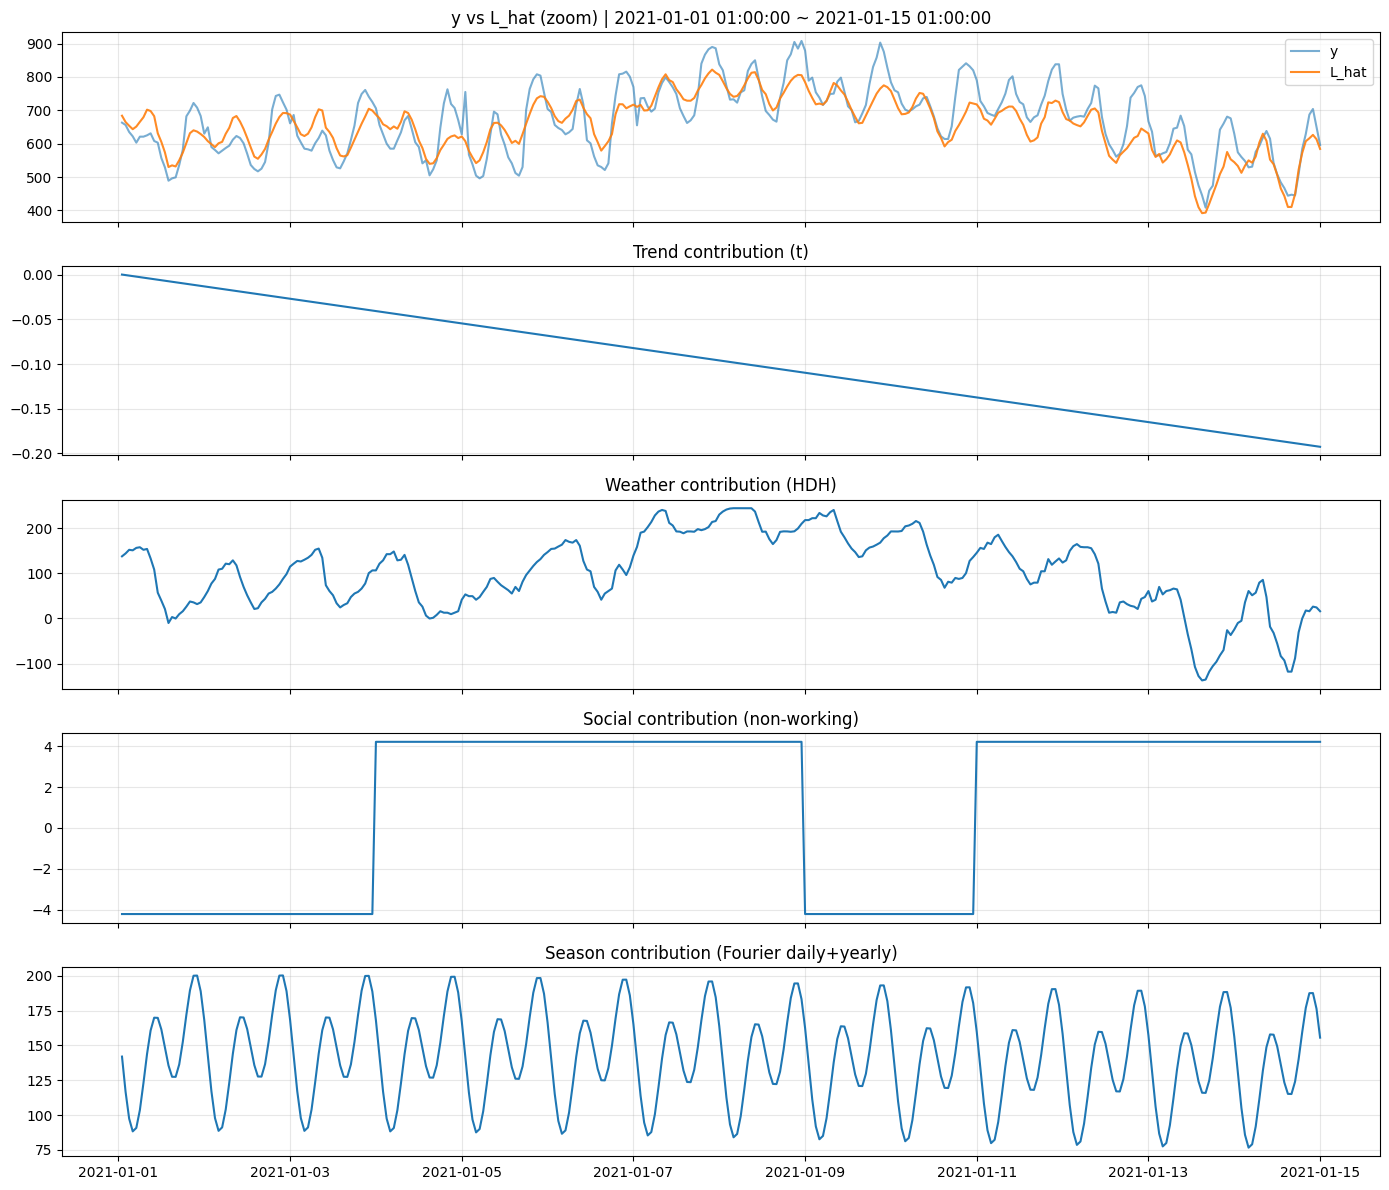

In [16]:
# =========================
# Stage I 구조 성분별 기여도 (zoom plot)
# =========================
df_stage1 = df_stage1 if "df_stage1" in globals() else df

start_dt = df_stage1["date"].iloc[0]
end_dt = start_dt + pd.Timedelta(hours=24*14)

mask = (df_stage1["date"] >= start_dt) & (df_stage1["date"] < end_dt)
x = df_stage1.loc[mask, "date"]

# GAM 예측 (fixed)
gam_pred_all = gam_fixed.predict(df_stage1[feature_cols_gam].values)

# CP 예측 (fixed)
cp_pred_all = cp_model_fixed.predict(df_stage1[cp_cols].values) if (cp_model_fixed is not None) else 0.0

L_hat_all = gam_pred_all + cp_pred_all

trend_contrib   = gam_fixed.partial_dependence(term=0, X=df_stage1[feature_cols_gam].values)
weather_contrib = gam_fixed.partial_dependence(term=1, X=df_stage1[feature_cols_gam].values)
social_contrib  = gam_fixed.partial_dependence(term=2, X=df_stage1[feature_cols_gam].values)

fourier_terms = [i for i, col in enumerate(feature_cols_gam) if col.startswith("daily_") or col.startswith("yearly_")]
season_contrib = 0.0
if len(fourier_terms) > 0:
    season_contrib = sum(gam_fixed.partial_dependence(term=i, X=df_stage1[feature_cols_gam].values) for i in fourier_terms)

fig, axes = plt.subplots(5, 1, figsize=(14, 12), sharex=True)

axes[0].plot(x, df_stage1.loc[mask, "heat_demand"], label="y", alpha=0.6)
axes[0].plot(x, L_hat_all[mask], label="L_hat", alpha=0.9)
axes[0].set_title(f"y vs L_hat (zoom) | {start_dt} ~ {end_dt}")
axes[0].legend()

axes[1].plot(x, trend_contrib[mask])
axes[1].set_title("Trend contribution (t)")

axes[2].plot(x, weather_contrib[mask])
axes[2].set_title("Weather contribution (HDH)")

axes[3].plot(x, social_contrib[mask])
axes[3].set_title("Social contribution (non-working)")

axes[4].plot(x, season_contrib[mask])
axes[4].set_title("Season contribution (Fourier daily+yearly)")

for ax in axes:
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 4. Stage II: Residual Dynamics with Seq2Seq LSTM

### 4.1 Residual Calculation - 논문 식 (13)

In [19]:
# Residual: r_t = y_t - L_hat_t (논문 식 13)
df['residual'] = df['heat_demand'] - L_hat_all

# Residual scaler (train만 fit)
residual_scaler = StandardScaler()
df.loc[:train_end-1, 'residual_scaled'] = residual_scaler.fit_transform(
    df.loc[:train_end-1, 'residual'].values.reshape(-1, 1)
).flatten()
df.loc[train_end:, 'residual_scaled'] = residual_scaler.transform(
    df.loc[train_end:, 'residual'].values.reshape(-1, 1)
).flatten()

print(f"Residual statistics (train):")
print(f"  Mean: {df.iloc[:train_end]['residual'].mean():.2f}")
print(f"  Std:  {df.iloc[:train_end]['residual'].std():.2f}")
print(f"\nScaled residual (train):")
print(f"  Mean: {df.iloc[:train_end]['residual_scaled'].mean():.4f}")
print(f"  Std:  {df.iloc[:train_end]['residual_scaled'].std():.4f}")


Residual statistics (train):
  Mean: -0.08
  Std:  37.65

Scaled residual (train):
  Mean: -0.0000
  Std:  1.0000


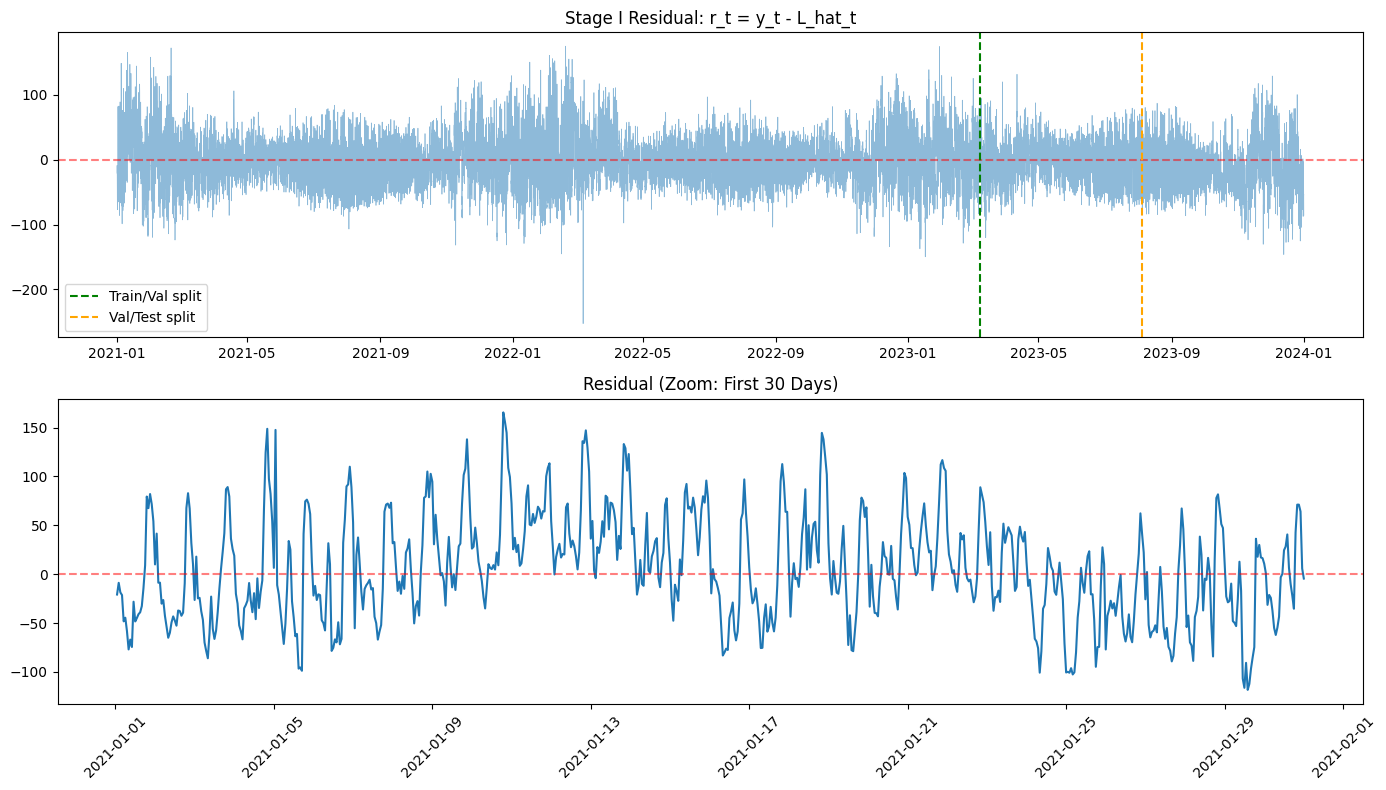

In [20]:
# Residual 시각화
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Full residual
axes[0].plot(df['date'], df['residual'], alpha=0.5, linewidth=0.5)
axes[0].axhline(0, color='red', linestyle='--', alpha=0.5)
axes[0].axvline(df.iloc[train_end]['date'], color='green', linestyle='--', label='Train/Val split')
axes[0].axvline(df.iloc[val_end]['date'], color='orange', linestyle='--', label='Val/Test split')
axes[0].set_title('Stage I Residual: r_t = y_t - L_hat_t')
axes[0].legend()

# Residual zoom (first month)
zoom_range = slice(0, 30*24)
axes[1].plot(df.iloc[zoom_range]['date'], df.iloc[zoom_range]['residual'])
axes[1].axhline(0, color='red', linestyle='--', alpha=0.5)
axes[1].set_title('Residual (Zoom: First 30 Days)')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Seq2Seq-LSTM 구조 생성

In [25]:
Y_COL = "heat_demand"

# 고정 Stage I 결과를 df에 반영
df["L_hat"] = L_hat_all

# Residual: y - L_hat
df["residual"] = df["heat_demand"] - df["L_hat"]

# 분할 인덱스 (기존 train_end/val_end 그대로 사용)
total_len = len(df)
idx_train = np.arange(0, train_end)
idx_val   = np.arange(train_end, val_end)
idx_test  = np.arange(val_end, total_len)

# 전체 배열
r_all = df["residual"].values.astype(np.float32)
L_all = df["L_hat"].values.astype(np.float32)
y_all = df[Y_COL].values.astype(np.float32)

# residual scaler: train만 fit
scaler_r = StandardScaler()
scaler_r.fit(r_all[idx_train].reshape(-1, 1))
r_all_s = scaler_r.transform(r_all.reshape(-1, 1)).reshape(-1).astype(np.float32)


In [36]:
# Stage I 고정 출력(L_hat_all)이 준비돼 있다고 가정
residual = df["heat_demand"].values - L_hat_all  # y - L_hat
scaler_r = StandardScaler()
scaler_r.fit(residual[:train_end].reshape(-1, 1))  # train만 fit
residual_s = scaler_r.transform(residual.reshape(-1, 1)).reshape(-1).astype(np.float32)


class NonOverlapSeq2SeqDataset(Dataset):
    def __init__(self, r_scaled, L_hat, y, t_indices, lookback=168, horizon=24):
        self.r = r_scaled
        self.L_hat = L_hat
        self.y = y
        self.t_idx = np.array(t_indices, dtype=int)
        self.lookback = lookback
        self.horizon = horizon

    def __len__(self):
        return len(self.t_idx)

    def __getitem__(self, i):
        t = self.t_idx[i]
        L = self.lookback
        H = self.horizon

        x = self.r[t-L+1 : t+1]            # (L,)
        y_r = self.r[t+1 : t+H+1]          # (H,)
        L_future = self.L_hat[t+1 : t+H+1] # (H,)
        y_future = self.y[t+1 : t+H+1]     # (H,)

        return (
            torch.tensor(x, dtype=torch.float32),
            torch.tensor(y_r, dtype=torch.float32),
            torch.tensor(L_future, dtype=torch.float32),
            torch.tensor(y_future, dtype=torch.float32),
        )

def make_cutoffs_for_split(N, lookback, horizon, stride, start, end):
    t_min = max(start + lookback - 1, lookback - 1)
    t_max = min(end - 1, N - horizon - 1)
    if t_min > t_max:
        return np.array([], dtype=int)
    return np.arange(t_min, t_max + 1, stride, dtype=int)

LOOKBACK = 168
HORIZON = 12
STRIDE = HORIZON

N = len(df)
L_all = L_hat_all.astype(np.float32)  # 고정 Stage I 결과
y_all = df["heat_demand"].values.astype(np.float32)
r_all_s = residual_s.astype(np.float32)  # 고정 Stage I residual을 scaler_r로 변환한 것

cut_train = make_cutoffs_for_split(N, LOOKBACK, HORIZON, STRIDE, start=0,        end=train_end)
cut_val   = make_cutoffs_for_split(N, LOOKBACK, HORIZON, STRIDE, start=train_end, end=val_end)
cut_test  = make_cutoffs_for_split(N, LOOKBACK, HORIZON, STRIDE, start=val_end,   end=N)

print("n_train samples:", len(cut_train))
print("n_val samples  :", len(cut_val))
print("n_test samples :", len(cut_test))

ds_train = NonOverlapSeq2SeqDataset(r_all_s, L_all, y_all, cut_train, LOOKBACK, HORIZON)
ds_val   = NonOverlapSeq2SeqDataset(r_all_s, L_all, y_all, cut_val,   LOOKBACK, HORIZON)
ds_test  = NonOverlapSeq2SeqDataset(r_all_s, L_all, y_all, cut_test,  LOOKBACK, HORIZON)


n_train samples: 1579
n_val samples  : 285
n_test samples : 284


In [37]:
import random

class Seq2SeqLSTM(nn.Module):
    def __init__(self, hidden_size=64, num_layers=1, dropout=0.0):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.encoder = nn.LSTM(
            input_size=1,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )
        self.decoder = nn.LSTM(
            input_size=1,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )
        self.out = nn.Linear(hidden_size, 1)

    def forward(self, x, horizon=24, teacher_forcing_ratio=0.0, y_tf=None):
        """
        x: (B, L) scaled residual history
        y_tf: (B, H) scaled residual targets (for teacher forcing)
        return: yhat (B, H)
        """
        B, L = x.shape
        x_enc = x.unsqueeze(-1)  # (B, L, 1)

        _, (h, c) = self.encoder(x_enc)  # use final state

        # decoder input: start token = last observed residual
        dec_in = x[:, -1].unsqueeze(-1).unsqueeze(-1)  # (B, 1, 1)

        outputs = []
        h_dec, c_dec = h, c
        for t in range(horizon):
            dec_out, (h_dec, c_dec) = self.decoder(dec_in, (h_dec, c_dec))
            y_step = self.out(dec_out)  # (B, 1, 1)
            outputs.append(y_step.squeeze(-1))  # (B, 1)

            use_tf = (y_tf is not None) and (random.random() < teacher_forcing_ratio)
            if use_tf:
                dec_in = y_tf[:, t].unsqueeze(-1).unsqueeze(-1)  # (B,1,1)
            else:
                dec_in = y_step.detach()

        yhat = torch.cat(outputs, dim=1)  # (B, H)
        return yhat


In [38]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [39]:
def run_epoch(model, loader, optimizer=None, teacher_forcing_ratio=0.0):
    train_mode = optimizer is not None
    model.train(train_mode)

    total_loss = 0.0
    n = 0
    loss_fn = nn.MSELoss()

    for x, y_r, _, _ in loader:
        x = x.to(device)
        y_r = y_r.to(device)

        if train_mode:
            optimizer.zero_grad()

        yhat = model(x, horizon=y_r.shape[1], teacher_forcing_ratio=teacher_forcing_ratio, y_tf=y_r)
        loss = loss_fn(yhat, y_r)

        if train_mode:
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

        bs = x.size(0)
        total_loss += loss.item() * bs
        n += bs

    return total_loss / max(n, 1)

@torch.no_grad()
def evaluate_recombined(model, loader):
    """
    residual 예측(D_hat) + 구조성분(L_hat_future)을 더해 y_hat 평가
    """
    model.eval()
    y_true_all = []
    y_pred_all = []

    for x, y_r_scaled, L_future, y_future in loader:
        x = x.to(device)
        yhat_r_scaled = model(x, horizon=y_r_scaled.shape[1], teacher_forcing_ratio=0.0, y_tf=None)
        yhat_r_scaled = yhat_r_scaled.cpu().numpy()

        # inverse scale residual
        yhat_r = scaler_r.inverse_transform(yhat_r_scaled.reshape(-1,1)).reshape(yhat_r_scaled.shape).astype(np.float32)

        L_future = L_future.numpy().astype(np.float32)
        y_future = y_future.numpy().astype(np.float32)

        yhat = L_future + yhat_r

        y_true_all.append(y_future.reshape(-1))
        y_pred_all.append(yhat.reshape(-1))

    y_true_all = np.concatenate(y_true_all)
    y_pred_all = np.concatenate(y_pred_all)

    mse = mean_squared_error(y_true_all, y_pred_all)
    return mse


In [40]:
def run_epoch(model, loader, optimizer=None, teacher_forcing_ratio=0.0):
    train_mode = optimizer is not None
    model.train(train_mode)

    total_loss = 0.0
    n = 0
    loss_fn = nn.MSELoss()

    for x, y_r, _, _ in loader:
        x = x.to(device)
        y_r = y_r.to(device)

        if train_mode:
            optimizer.zero_grad()

        yhat = model(x, horizon=y_r.shape[1], teacher_forcing_ratio=teacher_forcing_ratio, y_tf=y_r)
        loss = loss_fn(yhat, y_r)

        if train_mode:
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

        bs = x.size(0)
        total_loss += loss.item() * bs
        n += bs

    return total_loss / max(n, 1)

@torch.no_grad()
def evaluate_recombined(model, loader):
    """
    residual 예측(D_hat) + 구조성분(L_hat_future)을 더해 y_hat 평가
    """
    model.eval()
    y_true_all = []
    y_pred_all = []

    for x, y_r_scaled, L_future, y_future in loader:
        x = x.to(device)
        yhat_r_scaled = model(x, horizon=y_r_scaled.shape[1], teacher_forcing_ratio=0.0, y_tf=None)
        yhat_r_scaled = yhat_r_scaled.cpu().numpy()

        # inverse scale residual
        yhat_r = scaler_r.inverse_transform(yhat_r_scaled.reshape(-1,1)).reshape(yhat_r_scaled.shape).astype(np.float32)

        L_future = L_future.numpy().astype(np.float32)
        y_future = y_future.numpy().astype(np.float32)

        yhat = L_future + yhat_r

        y_true_all.append(y_future.reshape(-1))
        y_pred_all.append(yhat.reshape(-1))

    y_true_all = np.concatenate(y_true_all)
    y_pred_all = np.concatenate(y_pred_all)

    mse = mean_squared_error(y_true_all, y_pred_all)
    return mse


In [42]:
# train+val 컷오프
cut_trainval = make_cutoffs_for_split(len(df), LOOKBACK, HORIZON, STRIDE, start=0, end=val_end)

ds_trainval = NonOverlapSeq2SeqDataset(
    residual_s.astype(np.float32),           # 고정 Stage I residual (scaled)
    L_hat_all.astype(np.float32),            # 고정 Stage I L_hat
    df["heat_demand"].values.astype(np.float32),
    cut_trainval,
    LOOKBACK,
    HORIZON
)


from dataclasses import dataclass
import random

@dataclass
class HP:
    hidden_size: int
    num_layers: int
    dropout: float
    lr: float
    batch_size: int
    teacher_forcing: float

def sample_hp():
    return HP(
        hidden_size=random.choice([32, 64, 96, 128, 192]),
        num_layers=random.choice([1, 2, 3]),
        dropout=random.choice([0.0, 0.1, 0.2, 0.3]),
        lr=10 ** random.uniform(-4.0, -2.5),
        batch_size=random.choice([16, 32, 64]),
        teacher_forcing=random.choice([0.0, 0.2, 0.4, 0.6]),
    )

# -------------------------------
# 랜덤서치: max_epochs=20, patience=5
# -------------------------------
def fit_one_trial(hp: HP, trial_id=0):
    MAX_EPOCHS_RS = 20
    PATIENCE_RS = 5

    train_loader = DataLoader(ds_train, batch_size=hp.batch_size, shuffle=True, drop_last=False)
    val_loader   = DataLoader(ds_val,   batch_size=hp.batch_size, shuffle=False, drop_last=False)

    model = Seq2SeqLSTM(hidden_size=hp.hidden_size, num_layers=hp.num_layers, dropout=hp.dropout).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=hp.lr)

    best_val = float("inf")
    best_state = None
    bad = 0
    hist = []

    for epoch in range(1, MAX_EPOCHS_RS + 1):
        tr_loss = run_epoch(model, train_loader, optimizer=optimizer, teacher_forcing_ratio=hp.teacher_forcing)
        val_mse_y = evaluate_recombined(model, val_loader)
        hist.append((epoch, tr_loss, val_mse_y))

        if val_mse_y < best_val:
            best_val = val_mse_y
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            bad = 0
        else:
            bad += 1
            if bad >= PATIENCE_RS:
                break

    if best_state is not None:
        model.load_state_dict(best_state)

    return model, best_val, pd.DataFrame(hist, columns=["epoch", "train_loss_resid_scaled", "val_mse_y"])

N_TRIALS = 10  # 필요시 조정
trial_records = []
best_overall = float("inf")
best_hp = None
best_model = None
best_hist = None

for i in range(N_TRIALS):
    hp = sample_hp()
    model_i, val_mse_y, hist_df = fit_one_trial(hp, trial_id=i)
    rec = {"trial": i, "val_mse_y": val_mse_y, **hp.__dict__}
    trial_records.append(rec)
    print(f"[trial {i}] val_mse_y={val_mse_y:.4f} | hp={hp}")
    if val_mse_y < best_overall:
        best_overall = val_mse_y
        best_hp = hp
        best_model = model_i
        best_hist = hist_df

results_hp = pd.DataFrame(trial_records).sort_values("val_mse_y")
print("Best HP from search:", best_hp)


MAX_EPOCHS_FINAL = 100
PATIENCE_FINAL = 10

train_loader = DataLoader(ds_trainval, batch_size=best_hp.batch_size, shuffle=True, drop_last=False)
val_loader   = DataLoader(ds_val,     batch_size=best_hp.batch_size, shuffle=False, drop_last=False)

model_final = Seq2SeqLSTM(hidden_size=best_hp.hidden_size, num_layers=best_hp.num_layers, dropout=best_hp.dropout).to(device)
opt = torch.optim.Adam(model_final.parameters(), lr=best_hp.lr)

best_val = float("inf")
best_state = None
bad = 0

for epoch in range(1, MAX_EPOCHS_FINAL + 1):
    tr_loss = run_epoch(model_final, train_loader, optimizer=opt, teacher_forcing_ratio=best_hp.teacher_forcing)
    val_mse = evaluate_recombined(model_final, val_loader)

    if epoch == 1 or epoch % 5 == 0:
        print(f"[FINAL] epoch {epoch}/{MAX_EPOCHS_FINAL} | train_loss={tr_loss:.6f} | val_mse={val_mse:.6f}")

    if val_mse < best_val:
        best_val = val_mse
        best_state = {k: v.detach().cpu().clone() for k, v in model_final.state_dict().items()}
        bad = 0
    else:
        bad += 1
        if bad >= PATIENCE_FINAL:
            print(f"Early stop at epoch {epoch} (no val improvement for {PATIENCE_FINAL})")
            break

if best_state is not None:
    model_final.load_state_dict(best_state)

torch.save(model_final.state_dict(), "/Users/zongseung/Heat-Demand/CHP-project/best_lstm_model.pth")
print("Saved: best_lstm_model.pth")

[trial 0] val_mse_y=865.1688 | hp=HP(hidden_size=32, num_layers=2, dropout=0.3, lr=0.0018190461973648703, batch_size=16, teacher_forcing=0.0)
[trial 1] val_mse_y=826.7732 | hp=HP(hidden_size=64, num_layers=2, dropout=0.0, lr=0.001656064035547064, batch_size=16, teacher_forcing=0.6)
[trial 2] val_mse_y=936.7509 | hp=HP(hidden_size=64, num_layers=2, dropout=0.0, lr=0.00022307344702406318, batch_size=32, teacher_forcing=0.4)
[trial 3] val_mse_y=908.0741 | hp=HP(hidden_size=96, num_layers=2, dropout=0.1, lr=0.002102044661632835, batch_size=16, teacher_forcing=0.0)
[trial 4] val_mse_y=819.2556 | hp=HP(hidden_size=192, num_layers=2, dropout=0.1, lr=0.00037692207583242776, batch_size=16, teacher_forcing=0.4)
[trial 5] val_mse_y=1040.9360 | hp=HP(hidden_size=32, num_layers=2, dropout=0.2, lr=0.0016853020334115698, batch_size=16, teacher_forcing=0.4)
[trial 6] val_mse_y=929.9659 | hp=HP(hidden_size=64, num_layers=1, dropout=0.2, lr=0.00012105457552713459, batch_size=64, teacher_forcing=0.4)
[tr

Test samples: 284 blocks × 12 hours = 3408 predictions

=== Test Set Performance ===
MSE  : 1206.3149
RMSE : 34.7320
MAE  : 27.1462
MAPE : 18.69%
R²   : 0.9655


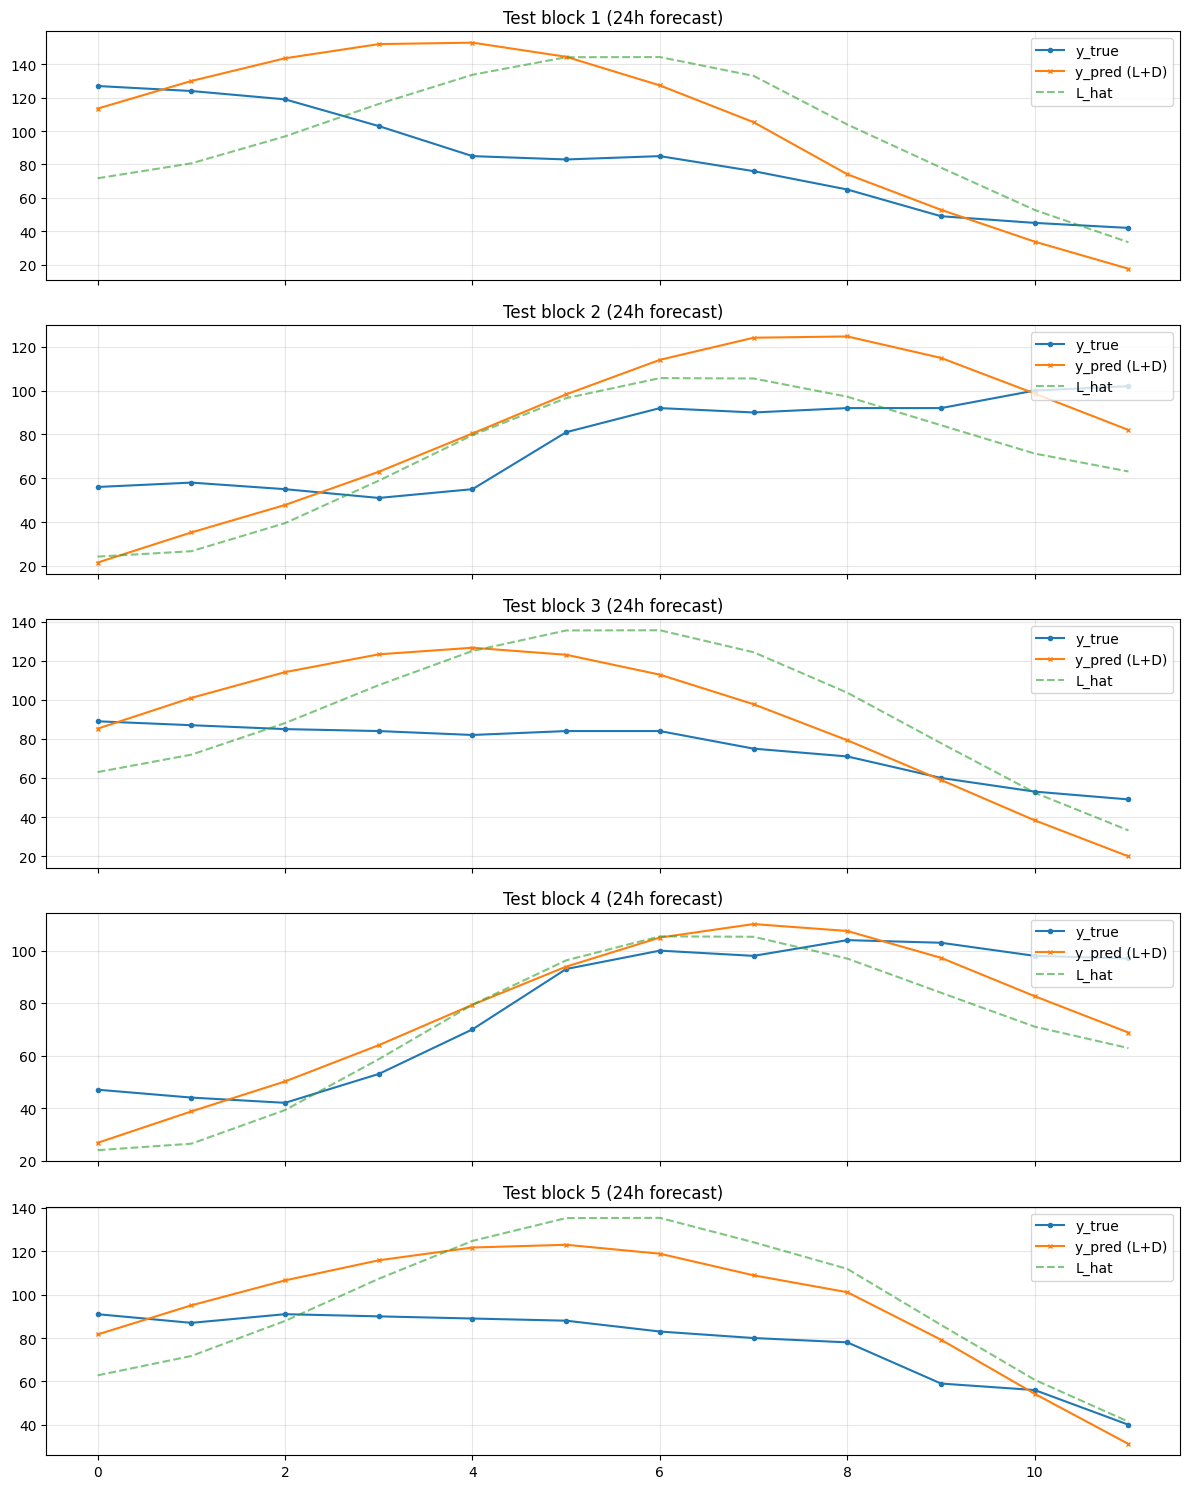

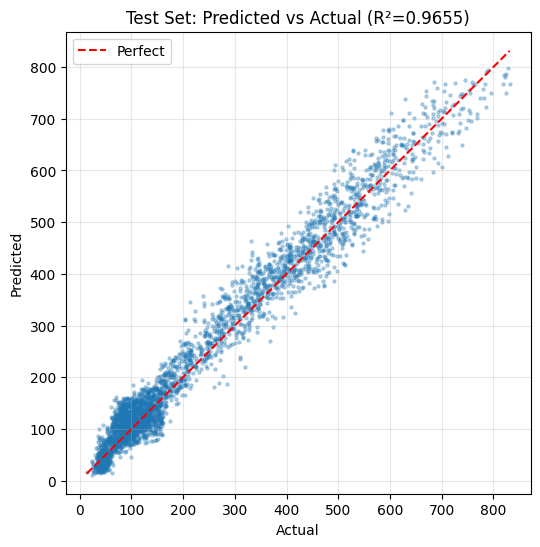

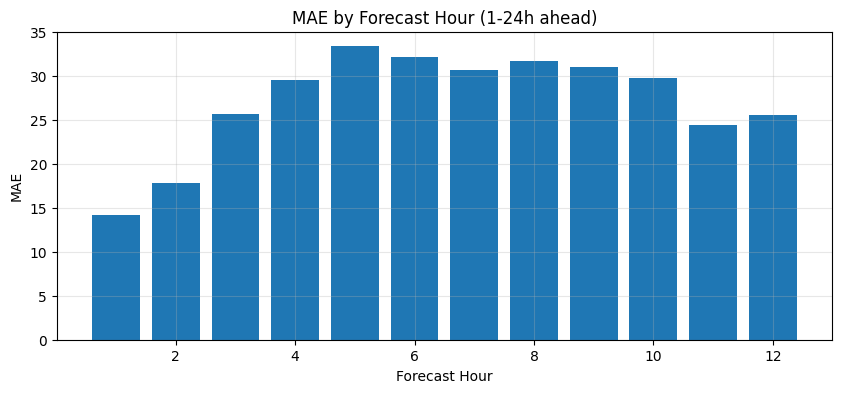

In [47]:
# test cutoffs + dataset + loader
cut_test = make_cutoffs_for_split(len(df), LOOKBACK, HORIZON, STRIDE, start=val_end, end=len(df))

ds_test = NonOverlapSeq2SeqDataset(
    residual_s.astype(np.float32),          # 고정 Stage I residual (scaled)
    L_hat_all.astype(np.float32),           # 고정 Stage I L_hat
    df["heat_demand"].values.astype(np.float32),
    cut_test,
    LOOKBACK,
    HORIZON
)

bs_test = best_hp.batch_size if "best_hp" in globals() and best_hp is not None else 32
test_loader = DataLoader(ds_test, batch_size=bs_test, shuffle=False, drop_last=False)


@torch.no_grad()
def evaluate_all_test(model, loader, scaler_r):
    """전체 test set에 대한 예측 및 평가"""
    model.eval()
    
    all_y_true = []
    all_y_pred = []
    all_L_hat = []
    all_D_hat = []
    
    for x, y_r_scaled, L_future, y_future in loader:
        x = x.to(device)
        yhat_r_scaled = model(x, horizon=y_r_scaled.shape[1], teacher_forcing_ratio=0.0)
        yhat_r_scaled = yhat_r_scaled.cpu().numpy()
        
        # inverse scale residual
        yhat_r = scaler_r.inverse_transform(
            yhat_r_scaled.reshape(-1, 1)
        ).reshape(yhat_r_scaled.shape).astype(np.float32)
        
        L_future = L_future.numpy().astype(np.float32)
        y_future = y_future.numpy().astype(np.float32)
        
        yhat = L_future + yhat_r
        
        all_y_true.append(y_future)
        all_y_pred.append(yhat)
        all_L_hat.append(L_future)
        all_D_hat.append(yhat_r)
    
    return (
        np.concatenate(all_y_true, axis=0),
        np.concatenate(all_y_pred, axis=0),
        np.concatenate(all_L_hat, axis=0),
        np.concatenate(all_D_hat, axis=0),
    )

# 전체 test set 예측
y_true_all, y_pred_all, L_all_test, D_all_test = evaluate_all_test(model_final, test_loader, scaler_r)

print(f"Test samples: {len(y_true_all)} blocks × {y_true_all.shape[1]} hours = {y_true_all.size} predictions")

# 메트릭 계산
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_true_flat = y_true_all.flatten()
y_pred_flat = y_pred_all.flatten()

mse = mean_squared_error(y_true_flat, y_pred_flat)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true_flat, y_pred_flat)
mape = np.mean(np.abs((y_true_flat - y_pred_flat) / (y_true_flat + 1e-8))) * 100
r2 = r2_score(y_true_flat, y_pred_flat)

print(f"\n=== Test Set Performance ===")
print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"MAE  : {mae:.4f}")
print(f"MAPE : {mape:.2f}%")
print(f"R²   : {r2:.4f}")

# 시각화 1: 전체 예측 vs 실제 (첫 N개 블록)
n_blocks_to_show = min(5, len(y_true_all))

fig, axes = plt.subplots(n_blocks_to_show, 1, figsize=(12, 3*n_blocks_to_show), sharex=True)
for i in range(n_blocks_to_show):
    ax = axes[i] if n_blocks_to_show > 1 else axes
    ax.plot(y_true_all[i], label="y_true", marker='o', markersize=3)
    ax.plot(y_pred_all[i], label="y_pred (L+D)", marker='x', markersize=3)
    ax.plot(L_all_test[i], label="L_hat", alpha=0.6, linestyle='--')
    ax.legend(loc='upper right')
    ax.set_title(f"Test block {i+1} (24h forecast)")
    ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 시각화 2: Scatter plot (예측 vs 실제)
plt.figure(figsize=(6, 6))
plt.scatter(y_true_flat, y_pred_flat, alpha=0.3, s=5)
plt.plot([y_true_flat.min(), y_true_flat.max()], 
         [y_true_flat.min(), y_true_flat.max()], 'r--', label='Perfect')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title(f"Test Set: Predicted vs Actual (R²={r2:.4f})")
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.show()

# 시각화 3: 시간별 에러 분포 (24시간 중 어느 시점이 어려운지)
hourly_mae = np.mean(np.abs(y_true_all - y_pred_all), axis=0)
plt.figure(figsize=(10, 4))
plt.bar(range(1, len(hourly_mae)+1), hourly_mae)
plt.xlabel("Forecast Hour")
plt.ylabel("MAE")
plt.title("MAE by Forecast Hour (1-24h ahead)")
plt.grid(True, alpha=0.3)
plt.show()

## GAM 만

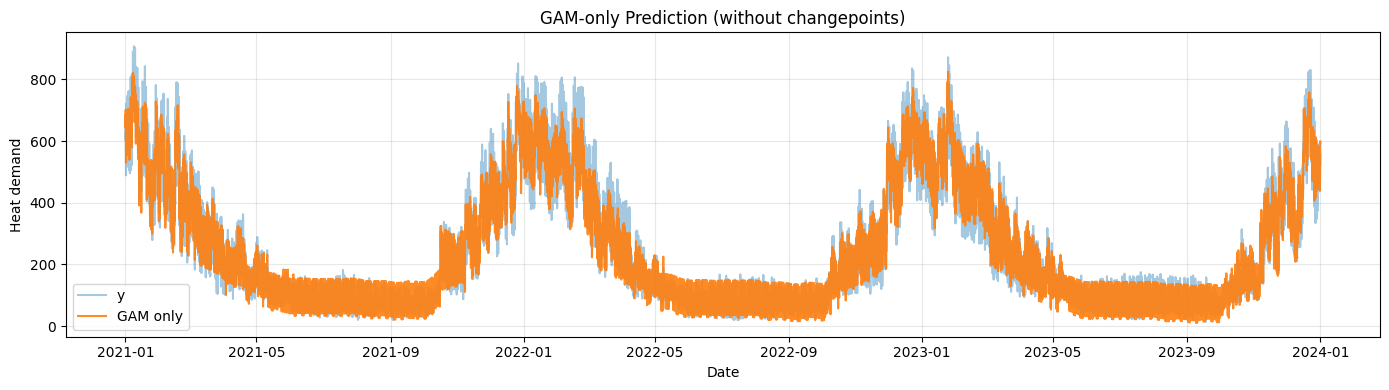

In [49]:
# fitting 부분에 대해서 
gam_only = gam_fixed.predict(df[feature_cols_gam].values)

plt.figure(figsize=(14, 4))
plt.plot(df["date"], df["heat_demand"], label="y", alpha=0.4)
plt.plot(df["date"], gam_only, label="GAM only", alpha=0.9)
plt.title("GAM-only Prediction (without changepoints)")
plt.xlabel("Date")
plt.ylabel("Heat demand")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [50]:
# =========================
# Stage I 고정 + LSTM 고정 슬라이딩 평가
# =========================
# 전제:
# - gam_fixed, cp_model_fixed, feature_cols_gam, cp_cols
# - model_final, scaler_r
# - LOOKBACK, HORIZON, STRIDE, val_end

# Stage I 고정 L_hat 계산 (전체 데이터)
gam_pred_all = gam_fixed.predict(df[feature_cols_gam].values)
cp_pred_all = cp_model_fixed.predict(df[cp_cols].values) if cp_model_fixed is not None else 0.0
L_hat_all = gam_pred_all + cp_pred_all

# residual (fixed Stage I 기준)
residual = df["heat_demand"].values - L_hat_all
residual_s = scaler_r.transform(residual.reshape(-1, 1)).reshape(-1).astype(np.float32)

# 슬라이딩 평가
ROLL_START = val_end
ROLL_END = len(df) - HORIZON
ROLL_STEP = STRIDE

y_true_all = []
y_pred_all = []

for t0 in range(ROLL_START, ROLL_END + 1, ROLL_STEP):
    # 과거 residual
    past_resid = residual_s[t0-LOOKBACK:t0]

    # 미래 구조 성분 (fixed Stage I)
    L_future = L_hat_all[t0:t0+HORIZON]
    y_true = df.iloc[t0:t0+HORIZON]["heat_demand"].values

    # LSTM 예측 (fixed)
    with torch.no_grad():
        x = torch.tensor(past_resid, dtype=torch.float32).unsqueeze(0).to(device)
        yhat_r_scaled = model_final(x, horizon=HORIZON, teacher_forcing_ratio=0.0).cpu().numpy().squeeze()

    yhat_r = scaler_r.inverse_transform(yhat_r_scaled.reshape(-1, 1)).reshape(-1)

    # 최종 예측
    yhat = L_future + yhat_r

    y_true_all.append(y_true)
    y_pred_all.append(yhat)

# Flatten and score
y_true_all = np.concatenate(y_true_all)
y_pred_all = np.concatenate(y_pred_all)

mse = mean_squared_error(y_true_all, y_pred_all)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true_all, y_pred_all)

print(f"Sliding (Fixed Stage I + Fixed LSTM)")
print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"MAE  : {mae:.4f}")


Sliding (Fixed Stage I + Fixed LSTM)
MSE  : 1203.4316
RMSE : 34.6905
MAE  : 27.0870


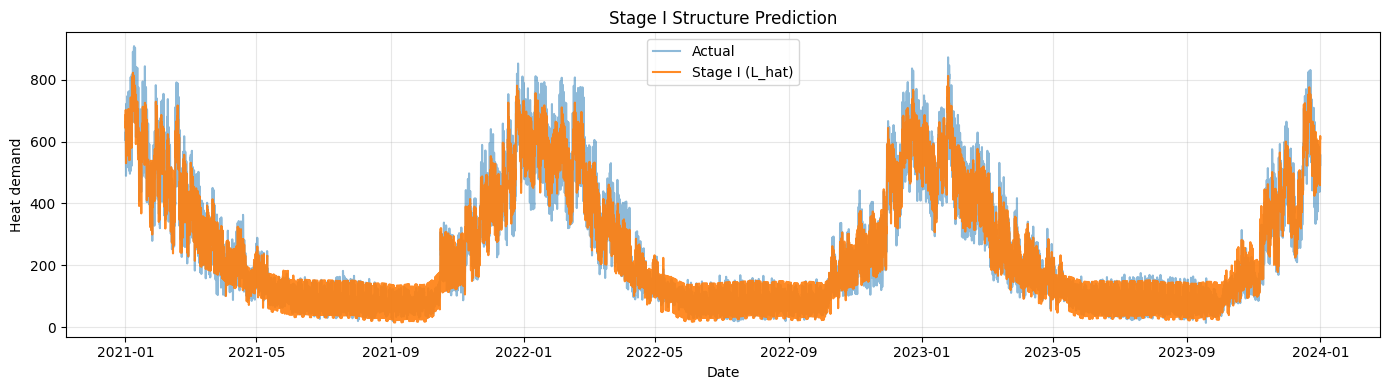

In [51]:
# Stage I 구조 예측 (L_hat_all) vs 실제
plt.figure(figsize=(14, 4))
plt.plot(df["date"], df["heat_demand"], label="Actual", alpha=0.5)
plt.plot(df["date"], L_hat_all, label="Stage I (L_hat)", alpha=0.9)
plt.title("Stage I Structure Prediction")
plt.xlabel("Date")
plt.ylabel("Heat demand")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [52]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# --- Stage I: test 구간 ---
y_test = df.iloc[val_end:]["heat_demand"].values
L_hat_test = L_hat_all[val_end:]  # Stage I 구조 예측

# --- Hybrid: test 구간 ---
# y_pred_all은 슬라이딩 예측 결과(Flattened)
y_pred_test = y_pred_all  # 이미 test 구간만 예측한 값이라 가정

def metrics(y_true, y_pred, name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100
    r2 = r2_score(y_true, y_pred)
    print(f"\n[{name}]")
    print(f"MSE  : {mse:.4f}")
    print(f"RMSE : {rmse:.4f}")
    print(f"MAE  : {mae:.4f}")
    print(f"MAPE : {mape:.2f}%")
    print(f"R²   : {r2:.4f}")

# Stage I vs Hybrid 비교
metrics(y_test, L_hat_test, "Stage I (GAM + cp)")
metrics(y_test[:len(y_pred_test)], y_pred_test, "Hybrid (GAM + LSTM)")


[Stage I (GAM + cp)]
MSE  : 1638.4124
RMSE : 40.4773
MAE  : 32.3715
MAPE : 23.05%
R²   : 0.9524

[Hybrid (GAM + LSTM)]
MSE  : 1203.4316
RMSE : 34.6905
MAE  : 27.0870
MAPE : 19.33%
R²   : 0.9649
